# TechFest & Krittika's Astrophysics Workshop 2020
## Session 3:
## Electromagnetic follow-up of Gravitational Wave events (EMGW)

**Lecture:**<br> 
**Prof. Mansi Manoj Kasliwal**, California Institute of Techonology (Caltech), Pasadena, LA.

**Workshop:**<br>
**Harsh Kumar** (Graduate student @ Indian Institute of Techonology, Bombay (IITB), LSSTC Data Science Fellow)<br>
**Gaurav Waratkar** (Graduate student @ Indian Institute of Techonology, Bombay (IITB))<br>

## Main Motive
 Measuring brightness of astronomical sources i.e. Understanding the concept of photometry.

## Key steps
- Extracting sources form image.
- Cross-match with some external catalogue to get Zeropoints.
- Calculating magnitudes using aperture photometry standardising the magnitudes.
- Performing PSF-fit photometry.

**Here are a few important notes before we get started:-**
- python3 environment is recommended for this notebook with the following modeules installed: (you can also make use of conda to make such an environment.)
- numpy
- matplotlib
- astropy
- photutils
- astroquery

If any of these modules are not installed, a simple pip insatll might do the job. i.e.  `pip install <module>`. You can also use conda to install these modules if you are working in a conda environment. If you are working with conda environment, you might want to make sure that your environment is active and pip is installed within your working conda environment to your conda environment

**We also require a few additional astrometic software dependency :-**
- SExtractor (source code Download link: https://www.astromatic.net/software)
- PSFEx    (source code Download link:  https://www.astromatic.net/software)



## Let's get started

Once again we start by importing necessary python modules. Do not run the next cell if you have all packages installed. 

In [ ]:
# ! pip install astroquery
# ! pip install astroscrappy
# ! pip install astropy
# ! sudo apt-get install psfex
# ! sudo add-apt-repository universe
# ! sudo apt-get install alien
# ! wget http://www.astromatic.net/download/sextractor/sextractor-2.19.5-1.x86_64.rpm
# ! alien -i sextractor-2.19.5-1.x86_64.rpm
# ! pip install photutils

In [ ]:
import os
import glob
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import subprocess
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, sigma_clip
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from astroquery.vizier import Vizier
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
from tqdm import tqdm_notebook as tqdm

In [ ]:
## Simple decorative display function. Please ignore
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
def display_text(text):
    print( color.GREEN + '*'+'-'*(10+len(text))+'*' )
    print('*'+('-'*3)+(' '*2)+ color.GREEN+ color.PURPLE+str(text)+ color.GREEN+(' '*2)+('-'*3)+'*')
    print('*'+'-'*(10+len(text))+'*' +"\n") 
    
def wait_request():
    print('This step may take a while. Please wait 🙏.\n')

In our last notebook, we have calibrated data and made it ready for the actual science purpose. It's time to use that. Do you remember where that data is ? Let's start by finding the calibrated data. All the calibrated / reduced data sits in reduced directory. So, reduced path will be the the one to go for in most of our processes in this notebook.  

In [ ]:
#Finding data 🧐

cwd = os.getcwd() # current working directory
science_path = os.path.join(cwd,'data','science')
reduced_path = os.path.join(cwd,'data','reduced')  # all processed data sits here. 

- Visualise the image to confirm that we are working with the correct data. Check whether it looks good or not. We have a few images available. You are free to use any of the image in theory. But, let's use the same image to compare the results. 

In [ ]:
os.chdir(reduced_path)
file_list = glob.glob("*.proc.fits")
print("found following {} files: {}".format(len(file_list), file_list))

In [ ]:
image = file_list[3]
hdu = fits.open(image)
data = hdu[0].data
header = hdu[0].header
mean, med, std = sigma_clipped_stats(data)
plt.figure(figsize= (10,10))
plt.imshow(data, vmin = med - 10*std, vmax = med + 10*std)
plt.colorbar()

# Photometry :  Photo (photons) + metry (measurement)
It's a technique by which we measure the Flux or intensity of the light emiited by a source. In other words, it is a method to measure the brightness of sources. We detect photons from the source onto a CCD camera and measure the number of photon collected in a given time. An estimation of photon flux from any particular source gives us its brightness. In astronomy we represents it in terms of magnitude of a source. Magnitude is represented as:

<center>
  m = -2.5 * log10(Flux)
</center>     

Here `m` is called "instrumental magnitude of a source". As we can see from the formula that it depends on Flux i.e.  number of photons collected by camera for a particular source. Number of photons collected by camera greatly depends on its specification and telescope assembly. Hence, this magnitude cooresponds to a particular camera assembly. Different cameras may register different Flux for the same source depending on various factors. Hence, the instrumental magnitude may vary with camera. As instrumental magnitude is not a standard thing we cannot use it directly on global scale. Therefore, we have to standardise it. We will do that later. Let's first understand how to estimate the instrumental magnitude.

# Two types of photometry:

## Aperture Photometry and PSF fit photometry

# Extracting sources from image
Now, we will extract sources from our image using `SExtractor`. `SExtractor` is a very versatile software, widely used by Astro commnunity for detecting sources from a fits images. Along with detecting sources it can also perform aperture and PSF photometry on sources if provided necessary parameters. These parameters are usally stored in the configuration file. `SExtractor` sources detection methods has been trained on various telescope images and are quite reliable. Although there exist better algorithms to perform photometry on sources, hardly any other software is as reliable as `SExtractor` in detecting sources. You can read more about `SExtractor` at  https://sextractor.readthedocs.io/en/latest/Introduction.html and https://www.astromatic.net/pubsvn/software/sextractor/trunk/doc/sextractor.pdf .



In [ ]:
# Let's define input and output file names
conf_file = 'config.sex'      # configuration file for SExtractor. This files consist of values of differet params
parameter_file = 'apr.param'  # parameter file which tells what params to be stored in catalogue file. 
out_cat = image + ".cat"      # Resulted catalogue from SExtractor consisting the sources info in the image.

In [ ]:
command =  ['sex', image, '-c', conf_file, '-CATALOG_NAME', out_cat, '-PARAMETERS_NAME', parameter_file]
print('SExtrator command is : %s' % command)
try:
    display_text("Running SExtractor")
    rval = subprocess.call(command)
    display_text("Process complete")
except subprocess.CalledProcessError as err:
    print('An error occuered while running SExtractor. Please try to run it manually through terminal.')
    sys.exit(1)

In [ ]:
def load_catalogue(catalogue, frames=1):
    """
    Load the sextractor generated catalogue in form of an astropy table.
    """
    if frames >0:
        frames = frames*2
    source_table= Table.read(catalogue, hdu=frames)
    return source_table

In [ ]:
local_sources = load_catalogue(out_cat)
print(local_sources.colnames)
print(local_sources)

# Source selection
Let's select the good sources from the sextrator catalogue. SExtractor flags the sources using 8 flag bits depending on various factors. You can read about the SExtrator flags in details here: https://sextractor.readthedocs.io/en/latest/Flagging.html

In [ ]:
unflagged_sources = local_sources[(local_sources['FLAGS'] == 0)]
print((unflagged_sources))

In [ ]:
from matplotlib.patches import Circle
fig = plt.figure(figsize=(20,20))
ax = fig.gca()
plt.imshow(data, vmin=med-3*std, vmax=med+3*std)
# Marking the position of sources in image.
stars = [Circle((obj['XWIN_IMAGE'], obj['YWIN_IMAGE']), radius = 15, edgecolor='w', facecolor='None') for obj in unflagged_sources]
for star in stars:
    ax.add_artist(star)
plt.show()

In [ ]:
w = WCS(header)
[ra_cent, dec_cent] = w.all_pix2world(header["NAXIS2"]/2, header["NAXIS1"]/2, 1)   # centeral ra dec of the image.
query_radius = 23 # catalogue query radius around central ra dec in arcmins.
minmag = 14    # maximum magnitude cut to get rid of very bright stars
maxmag = 18    # minimum magnitude cut to get rid of very faint stars    

# Keep in mind: more the magnitude of the star, less brighter it is.

pan_catnum = "II/349"  #This is the catalog number of PanSTARRS DR1 in Vizier.
#  Use 'V/147' to query SDSS catalogue in Vizier. You have to replace colomn header names in last line as those are different for SDSS.

display_text('Making a vizier query for %s catalogue number in %.f arcmin radius around Ra %.5f, Dec %.5f'%(pan_catnum, query_radius, ra_cent, dec_cent))
wait_request()
try:
    v = Vizier(columns=['*'], column_filters={"gmag":"<%.1f"%maxmag, "e_gmag":"<<1.086/3", "Nd":">6"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra = ra_cent, dec = dec_cent, unit = (u.deg, u.deg)), radius = str(query_radius)+'m', catalog=pan_catnum, cache=False)
    good_stars = Q[0][Q[0]['gmag'] > minmag]  # Neglecting very bright stars from the queried catalogue.
    print("\n\n Vizier query resulted %.f sources in the queried field after applying the mentioned filtering criteria."%len(good_stars))
except:
    print('An error occured in querying vizier database. Please check whether your internet conection is working or not.')

# Convert the queried source positions to image pixel position using world2pix conversion for later use.
cat_localcoords = w.all_world2pix(good_stars['RAJ2000'], good_stars['DEJ2000'], 1) # position of queried sources in the image.

In [ ]:
print(good_stars)

# Exercise time!

### Plot where the queried surces lies in the image. You will have to do something like we did for the case of unflagged sources.  Add a cell below for the same.


In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow()
circles = 

plt.show()

In [ ]:
local_catcoords = SkyCoord(ra=unflagged_sources['ALPHAWIN_J2000'], dec=unflagged_sources['DELTAWIN_J2000'], frame='icrs', unit='degree')
pan_catcoords = SkyCoord(ra=good_stars['RAJ2000'], dec=good_stars['DEJ2000'], frame='icrs', unit='degree')

photoDistThresh = 0.676   # cross-match radius
pan_idx, local_idx, d2d, d3d = local_catcoords.search_around_sky(pan_catcoords, photoDistThresh*u.arcsec)

print('Found %d good cross-matches'%len(local_idx))

In [ ]:
medFWHM = (np.median(unflagged_sources['FWHM_WORLD'][local_idx])* 3600)/0.676
print("median FWHM of the image is: %.2f pixels"%(medFWHM))

In [ ]:
a_max =int(np.round((2*medFWHM), 0))
print(a_max)

aperture_diameter = np.arange(5,a_max+1)
print(aperture_diameter)
print(len(aperture_diameter), len(local_idx))
zero_points = []
for i in range(len(aperture_diameter)):
    offsets = np.ma.array(good_stars['gmag'][pan_idx] - unflagged_sources['MAG_APER'][:,i][local_idx])
    zero_mean, zero_med, zero_std = sigma_clipped_stats(offsets)
    zp_dict = {'diameter': aperture_diameter[i], 'zp_mean': np.round(zero_mean,3), 'zp_median': np.round(zero_med,3), 'zp_std': np.round(zero_std, 3)}
    zero_points.append(zp_dict)
    print(zp_dict)

In [ ]:
# Let's see how good or bad is the ZP estimation is.
plt.scatter(np.arange(len(offsets)), offsets, alpha = 0.2)
plt.axhline(zero_med, color= 'r', linestyle = '--')

You can also check the relationship between instric magnitude and magnitude from panSTARRS. They should follow a linear trend.

# So, this brings us to the next Exercise!

#### Plot the instrinsic magnitude Vs ps1 magniudes and see if they follow a linear trend or not.  

In [ ]:
# Exercise 2 solution here: 
plt.figure(figsize=(8,8))
plt.scatter()
plt.scatter()
plt.xlabel('PanSTARRS mag', fontsize=20)
plt.ylabel('Instrumental psf mag', fontsize=20)
plt.ylim()
plt.legend()
plt.show()

In [ ]:
ra = 324.8157058   # RA of the source
dec = 46.7339800   # Dec of the source

position = SkyCoord(ra = ra, dec = dec, unit = u.deg, frame = 'icrs')

radii_max =int(np.round(medFWHM, 0))
aperture_radii= np.arange(1,radii_max+1)
print(aperture_radii)
apertures = [SkyCircularAperture(position, r = r * u.pix) for r in aperture_radii]
pix_apertures = [a.to_pixel(w) for a in apertures]

phot_table = aperture_photometry(data, pix_apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

In [ ]:
# Create the annulus aperture for background estimation
anuRadius = int(np.round(4*medFWHM, 0))
anuWidth =  3

annulus_aperture = SkyCircularAnnulus(position, r_in = anuRadius * u.pix, r_out = (anuRadius + anuWidth) * u.pix)
pix_annulus_aperture = annulus_aperture.to_pixel(w)

#Measuring the flux inside an aperture annulus
error = np.sqrt(data)  # error array for each pixel value.
annulus_phot_table = aperture_photometry(data, pix_annulus_aperture, error = error)
for col in annulus_phot_table.colnames:
        annulus_phot_table[col].info.format = '%.8g'
#print the output
print(annulus_phot_table)

In [ ]:
bkg_mean = annulus_phot_table['aperture_sum'] / pix_annulus_aperture.area
bkg_flux = bkg_mean * pix_apertures[-1].area
print('aperture_sum_%d'%i)
source_flux = phot_table['aperture_sum_%d'%(radii_max-1)] - bkg_flux
int_mag_err=2.5*np.log10(1 + annulus_phot_table['aperture_sum_err'] / source_flux)
e_mag= np.sqrt(int_mag_err**2+zero_points[-1]['zp_std']**2)
source_mag = zero_points[-1]['zp_median'] - 2.5 * np.log10(source_flux)
print('Found source magnitude of %.2f +/- %0.2f for aperture of radius %d pixels'%(source_mag, e_mag, aperture_radii[-1]))

# PSF-fit photometry:


In [ ]:
psf_config = 'config.psfex'
psfex_command =  ['psfex', '-c', psf_config, out_cat]
print('PSFEx command is : %s'%psfex_command)
try:
    display_text("Running PSFEx")
    wait_request()
    rval = subprocess.call(psfex_command)
    display_text("Process complete")
except subprocess.CalledProcessError as err:
    print('An error occuered while running PSFEx on %s. Please try to run it manually through terminal.'%image)
    sys.exit(1)

In [ ]:
psf_hdu = fits.open('moffat_'+image+'.fits')[0]
psf_data = psf_hdu.data
psf_mean, psf_median, psf_std = sigma_clipped_stats(psf_data)
plt.figure(figsize=(6,6))
plt.imshow(psf_data, vmin = psf_median - 3*psf_std, vmax = psf_median + 10*psf_std)
plt.show()

In [ ]:
psf_model = image + '.psf'
out_psfcat = image+'.psf.cat'
parameter_file = 'photomPSF.param'  # psf photometry parameter file for SExtrator

# Let's run sextrator again. But, this time with psf model as input to perform psf photometry.
command = ['sex', image, '-c', conf_file, '-CATALOG_NAME', out_psfcat, '-PARAMETERS_NAME', parameter_file, '-PSF_NAME', psf_model]  
try:
    display_text("Running SExtractor")
    wait_request()
    rval = subprocess.call(command)
    display_text("Process complete")
except subprocess.CalledProcessError as err:
    print('An error occuered while running SExtractor. Please try to run it manually through terminal.')
    sys.exit(1)

In [ ]:
local_psfsources = load_catalogue(out_psfcat)

# Spend a minute on comparing the new and older sextrator catalogue table columns and see what now in recent catalogue.
print(local_psfsources.colnames)

print("\n\nFound {} sources".format(len(local_psfsources)))

In [ ]:
# Selecting good sources:
unflagged_psfsources = local_psfsources[(local_psfsources['FLAGS']==0) & (local_psfsources['FLAGS_MODEL']==0)  & (local_psfsources['FWHM_WORLD']*3600 < 5)]

In [ ]:
local_psf_catcoords = SkyCoord(ra=unflagged_psfsources['ALPHAWIN_J2000'], dec=unflagged_psfsources['DELTAWIN_J2000'], frame='icrs', unit='degree')
cross_match_radius = 0.676
local_psfidx, pan_psfidx, d2d, d3d = pan_catcoords.search_around_sky(local_psf_catcoords, cross_match_radius*u.arcsec)

print('Found %d good cross-matches'%len(local_psfidx))

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(good_stars['gmag'][ pan_psfidx], unflagged_psfsources['MAG_POINTSOURCE'][local_psfidx] , 'go', alpha = 0.5)
plt.xlabel('PanSTARRS mag', fontsize=20)
plt.ylabel('Instrumental psf mag', fontsize=20)
plt.ylim(-12.5, -8)
plt.show()

In [ ]:
# Get the zeropoint of the image by crossd matching the psf photometry of sources. 
psfoffsets = np.ma.array(good_stars['gmag'][ pan_psfidx] - unflagged_psfsources['MAG_POINTSOURCE'][local_psfidx])
zp_psfmean, zp_psfmed, zp_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF mean zp: %.3f, PSF median zp: %.3f,  PSF std zp: %.3f'%(zp_psfmean, zp_psfmed, zp_psfstd))

In [ ]:
target_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_target, local_idx_psf_target, d2d, d3d = local_psf_catcoords.search_around_sky(target_coords, cross_match_radius*u.arcsec)
if len(local_idx_psf_target) > 0:
    print('Source found in SExtrator catalogue')
else:
    print("Unable to locate source in SExtrator catalogue")

int_psf_mag = unflagged_psfsources[local_idx_psf_target]['MAG_POINTSOURCE'][0]
int_psf_magerr = unflagged_psfsources[local_idx_psf_target]['MAGERR_POINTSOURCE'][0]

psfmag =  int_psf_mag + zp_psfmed
e_psfmag = np.sqrt(int_psf_magerr**2 + zp_psfstd**2)

In [ ]:
print('PSF magnitude of target is %.2f +/- %.2f'%(psfmag, e_psfmag))

# Need of Image subtraction


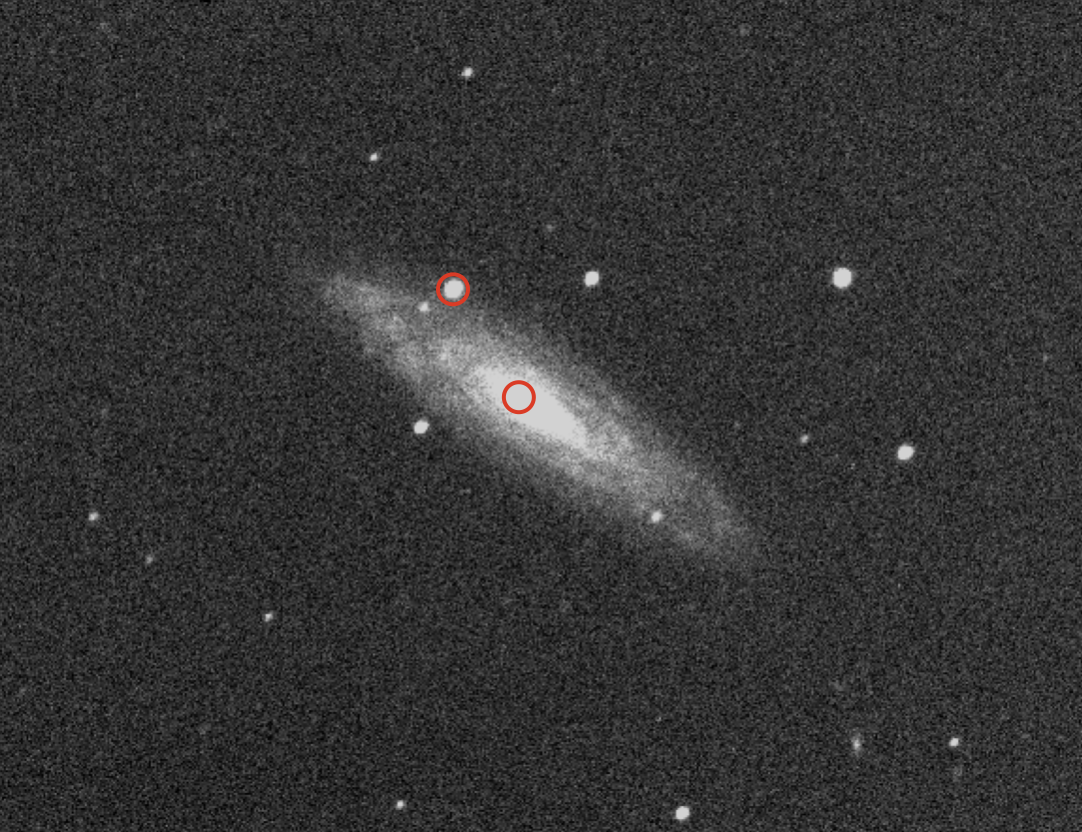

# Try it out yourself!